In [1]:
from ipykernel import kernelapp as app
#import pypyodbc as podbc
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from ipykernel import kernelapp as app
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm

In [12]:
conn=podbc.connect("Driver={SQL Server};Server=CZPHAAADS01;Database=Pricing;uid=data_reader;pwd=data_reader123")

myqr="SELECT * FROM [Pricing].[dbo].[sold2016_7allnew_anchored_cars];"       # training set 
cars = pd.read_sql_query(myqr, conn)

myqr="SELECT * FROM [Pricing].[dbo].[model_codes];"                                  
model_code = pd.read_sql_query(myqr, conn)                                   # transform to (make_)model_cd

myqr="SELECT * FROM [Pricing].[dbo].[Sauto_all2017_new_anchors];"
cars_anchors = pd.read_sql_query(myqr, conn)                                 # mask table

myqr="SELECT * FROM [Pricing].[dbo].[brand_mmcode];"                         # mmcode from Sauto
brand_mmcode = pd.read_sql_query(myqr, conn)
  
myqr="SELECT [mmcode] AS [tscode], [make_model], [counts] FROM [Pricing].[dbo].[train_make_model_count];"                          # mmcode from train set
train_mmcode = pd.read_sql_query(myqr, conn)

myqr="SELECT * FROM [Pricing].[dbo].[years_med_anchors]"           # median anchors per make_model and year
years_med_anchors = pd.read_sql_query(myqr, conn)                                         

myqr="SELECT * FROM [Pricing].[dbo].[median_anchors]"              # median anchors per make_model
unanchored = pd.read_sql_query(myqr, conn) 

myqr="SELECT [car_segment] AS [tscode], [make_model], [rafo_model] AS [rafo_pkl_file] FROM [Pricing].[dbo].[RAFO_withIFC_new_anchor_120models] ;" 

rafo_pkl_files = pd.read_sql_query(myqr, conn)
ralen = len(rafo_pkl_files)
rafo_files= [0]*ralen
rafos = [""]*ralen
for i in range(ralen):
    rafo_files[i] = rafo_pkl_files.loc[i,"rafo_pkl_file"]
    rafos[i] = pickle.loads(rafo_pkl_files.loc[i,"rafo_pkl_file"] )
print(ralen)

121


#### Training set analysis

In [5]:
cols_to_int = ["id","makeyear","age","power","sizeccm","automat","drive","mec_con","ext_con","isfirstowner",
               "isservicebook","isvat","autoaircondition","airconditioned","isxenon","isled","isnavigation",
               "iscruisecontrol","isinleather","airbags","revage","revkm","make_cd","model_cd","body_cd",
               "fuel_cd","anchor","mmcode"]
ctilen = len(cols_to_int)
for i in range(0, ctilen):
    #print(cols_to_int[i])
    cars[cols_to_int[i]] = cars[cols_to_int[i]].apply(lambda ct: int(ct))
cars.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,airbags,revage,revkm,make_cd,model_cd,body_cd,fuel_cd,price,mmcode,anchor
0,900004590,opel,meriva,opelmeriva,2015,13.190,21,88,1364,compact mpv,...,0,1272,1429,11,354,7,2,320.0,52,299000
1,900013465,opel,meriva,opelmeriva,2015,12.050,19,88,1364,compact mpv,...,0,1406,1565,11,354,7,2,320.0,52,299000
2,900014331,opel,meriva,opelmeriva,2015,10.037,17,88,1364,compact mpv,...,0,1572,1878,11,354,7,2,335.0,52,299000
3,900013478,opel,meriva,opelmeriva,2015,13.978,19,88,1364,compact mpv,...,0,1406,1349,11,354,7,2,340.0,52,299000
4,900013481,opel,meriva,opelmeriva,2015,12.534,15,88,1364,compact mpv,...,0,1781,1504,11,354,7,2,370.0,52,299000


In [6]:
calen = len(cars)
calen

76174

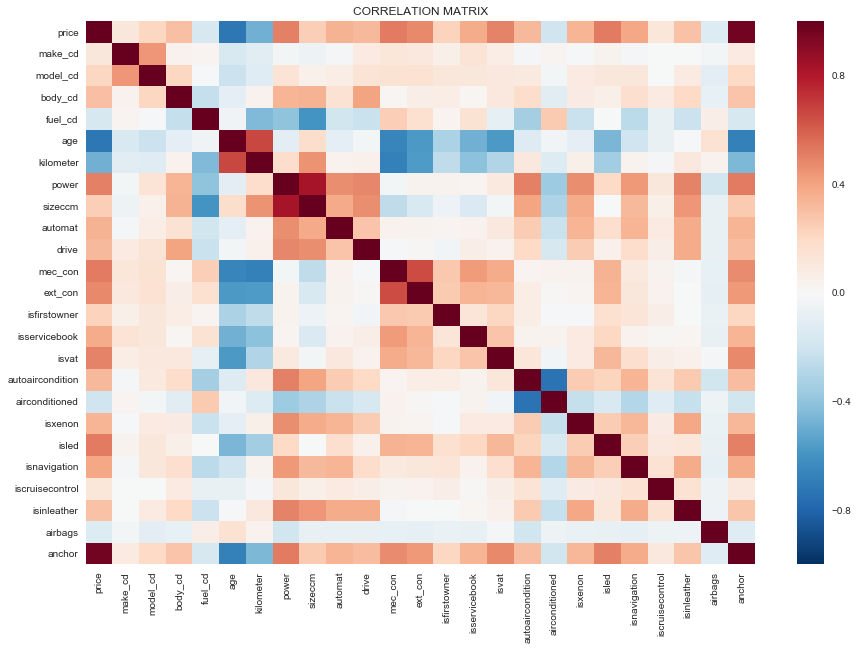

In [7]:
col_to_plt=["price","make_cd", "model_cd", "body_cd", "fuel_cd", "age","kilometer","power","sizeccm",
            "automat","drive","mec_con","ext_con","isfirstowner","isservicebook","isvat","autoaircondition",
            "airconditioned","isxenon","isled","isnavigation","iscruisecontrol","isinleather","airbags","anchor"]
cars_to_plt = cars[col_to_plt]
correm = cars_to_plt.corr()
plt.figure(figsize=(15, 10))
sns.set_context("notebook", font_scale=1.0)
plt.title('CORRELATION MATRIX')
sns.heatmap(correm, xticklabels=correm.columns.values,yticklabels=correm.columns.values)

In [8]:
cars = cars.head(20000)

In [9]:
cars['model'].unique()

array(['meriva', 'caddy', 'octavia', 'grand vitara', 'sportage', 'ml',
       'a3', 'passat', '3', 'i20', 'scenic', 'megane scenic', 'a', 'fabia'], dtype=object)

In [10]:
len(cars[cars.model=='passat'])

2953

In [19]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import neighbors
import matplotlib.patches as mpatches

my_model = "passat"
def label_scatter_plot(X, y, labels):
    lablen = len(labels)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    marker_array = ['o', '^', '*']
    mycolors = ['#3300FF', '#FF0033']
    sns.set_context("notebook", font_scale=1.2)
    cmap_bold = ListedColormap(mycolors)
    boundnorm = BoundaryNorm(np.arange(0, lablen + 1, 1), ncolors=lablen)
    plt.figure(figsize=(11,7))
    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = boundnorm, alpha = 0.40,
                edgecolor='#000000', lw = 1 )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    h = []
    for c in range(0, lablen):
        h.append(mpatches.Patch(color=mycolors[c], label=labels[c]))
    plt.legend(handles=h)   
def model_labels(mk):
    if ((mk==my_model)==True):
        return 1
    return 0
    
cars['model_lab'] = cars['model'].apply(model_labels)
my_labels = ['others', my_model ]
columns_to_trans = ['model_lab','make_cd','model_cd','body_cd','fuel_cd','kilometer','age','power','sizeccm','automat','drive',
                    'mec_con','ext_con','anchor']
my_features = columns_to_trans[1:]
X_trans = cars[columns_to_trans[1:]]
X_normalized = StandardScaler().fit(X_trans).transform(X_trans)
y_trans = cars[columns_to_trans[0]]

tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(X_normalized)
print('transformed')

transformed


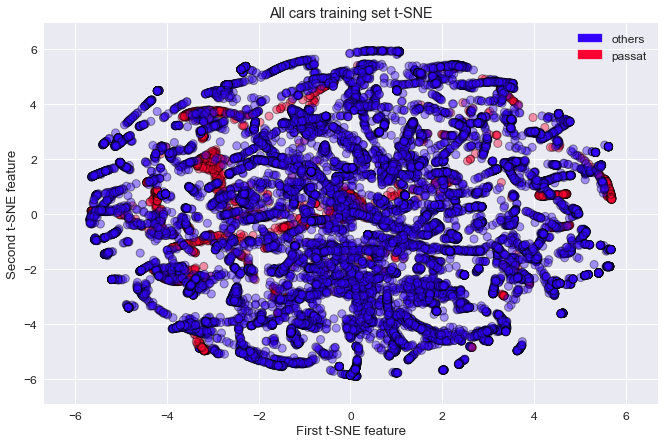

In [20]:
sns.set_context("notebook", font_scale=1.1)
label_scatter_plot(X_tsne, y_trans, my_labels )
plt.xlabel('First t-SNE feature')
plt.ylabel('Second t-SNE feature')
plt.title('All cars training set t-SNE')
plt.show()

In [ ]:
myqr="SELECT * FROM [Pricing].[dbo].[sold2016_7allsC_pow_anchor_cars];"                 # training set 
cars = pd.read_sql_query(myqr, conn)

In [13]:
cols_to_int = ["id","makeyear","age","power","sizeccm","automat","drive","mec_con","ext_con","isfirstowner","isservicebook",
               "isvat","autoaircondition","airconditioned","isxenon","isled","isnavigation","iscruisecontrol","isinleather",
               "airbags","revage","revkm","make_cd","model_cd","body_cd","fuel_cd","anchor","mmcode"]
ctilen = len(cols_to_int)
for i in range(0, ctilen):
    cars[cols_to_int[i]] = cars[cols_to_int[i]].apply(lambda ct: int(ct))
cars.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,airbags,revage,revkm,make_cd,model_cd,body_cd,fuel_cd,price,mmcode,anchor
0,900004590,opel,meriva,opelmeriva,2015,13.190,21,88,1364,compact mpv,...,0,1272,1429,11,354,7,2,320.0,52,299000
1,900013465,opel,meriva,opelmeriva,2015,12.050,19,88,1364,compact mpv,...,0,1406,1565,11,354,7,2,320.0,52,299000
2,900014331,opel,meriva,opelmeriva,2015,10.037,17,88,1364,compact mpv,...,0,1572,1878,11,354,7,2,335.0,52,299000
3,900013478,opel,meriva,opelmeriva,2015,13.978,19,88,1364,compact mpv,...,0,1406,1349,11,354,7,2,340.0,52,299000
4,900013481,opel,meriva,opelmeriva,2015,12.534,15,88,1364,compact mpv,...,0,1781,1504,11,354,7,2,370.0,52,299000


In [14]:
len(cars['model'].unique())

491

In [15]:
len(cars[cars.model=='octavia'])

9231

In [16]:
len(cars[cars.mmcode<=120])                  # mmcode based on sold tops 

64709

In [17]:
cars1 = pd.read_csv("bought_to5AprC_new_anch_allcarsUP.csv", engine='python', encoding='Latin_1')      # outfile input
calen1 = len(cars1)   
calen1    

13200

In [18]:
cars1.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,airbags,revage,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price
0,900120606,skoda,rapid,skodarapid,2017,8.318,15,70,999,hatchback,...,0,1843.0,2260.0,28,381,4,2,0,370,326.0
1,900119544,skoda,rapid,skodarapid,2017,8.507,15,70,999,hatchback,...,0,1843.0,2210.0,28,381,4,2,0,370,335.0
2,900110461,skoda,rapid,skodarapid,2017,9.090,15,70,999,hatchback,...,0,1843.0,2068.0,28,381,4,2,0,370,380.0
3,900138780,skoda,rapid,skodarapid,2017,4.137,17,70,999,hatchback,...,0,1626.0,4545.0,28,381,4,2,0,370,376.0
4,900151780,skoda,rapid,skodarapid,2017,0.091,17,70,999,hatchback,...,0,1626.0,206659.0,28,381,4,2,0,370,320.0


In [19]:
cars1 = pd.merge(cars1, train_mmcode, on="make_model", how='outer')
print(len(cars1)) 

13257


In [20]:
cars1 = cars1.head(calen1)

In [21]:
calen1

13200

In [22]:
cars1["tscode"].fillna(0,inplace=True)
cars1["counts"].fillna(0,inplace=True)
missing_mms = cars1[cars1.tscode==0] 
len(missing_mms)

55

In [23]:
missing_mms.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price,tscode,counts
3004,900148825.0,skoda,favorit,skodafavorit,1990.0,95.933,665.0,43.0,1289.0,hatchback,...,196.0,28.0,123.0,4.0,2.0,0.0,16.0,16.0,0.0,0.0
3005,900152215.0,skoda,favorit,skodafavorit,1989.0,47.019,697.0,46.0,1289.0,hatchback,...,399.0,28.0,123.0,4.0,2.0,0.0,16.0,80.0,0.0,0.0
3006,900146433.0,skoda,favorit,skodafavorit,1990.0,28.726,659.0,40.0,1289.0,hatchback,...,654.0,28.0,123.0,4.0,2.0,0.0,16.0,70.0,0.0,0.0
6567,900144720.0,mazda,121,mazda121,2000.0,76.998,431.0,55.0,1242.0,hatchback,...,244.0,32.0,73.0,4.0,2.0,0.0,16.0,30.0,0.0,0.0
6576,900138500.0,fiat,cinquecento,fiatcinquecento,1996.0,150.912,513.0,40.0,1108.0,hatchback,...,124.0,16.0,438.0,4.0,2.0,0.0,14.0,20.0,0.0,0.0


In [24]:
cols_to_int = ["id","makeyear","age","power","sizeccm","automat","drive","mec_con","ext_con","isfirstowner","isservicebook",
               "isvat","autoaircondition","airconditioned","isxenon","isled","isnavigation","iscruisecontrol","isinleather",
               "airbags","make_cd","model_cd","body_cd","fuel_cd","anchor","tscode"]
ctilen = len(cols_to_int)
for i in range(0, ctilen):
    cars1[cols_to_int[i]] = cars1[cols_to_int[i]].apply(lambda ct: int(ct))
cars1.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price,tscode,counts
0,900120606,skoda,rapid,skodarapid,2017,8.318,15,70,999,hatchback,...,2260.0,28,381,4,2,0.0,370,326.0,16,640.0
1,900119544,skoda,rapid,skodarapid,2017,8.507,15,70,999,hatchback,...,2210.0,28,381,4,2,0.0,370,335.0,16,640.0
2,900110461,skoda,rapid,skodarapid,2017,9.090,15,70,999,hatchback,...,2068.0,28,381,4,2,0.0,370,380.0,16,640.0
3,900138780,skoda,rapid,skodarapid,2017,4.137,17,70,999,hatchback,...,4545.0,28,381,4,2,0.0,370,376.0,16,640.0
4,900151780,skoda,rapid,skodarapid,2017,0.091,17,70,999,hatchback,...,206659.0,28,381,4,2,0.0,370,320.0,16,640.0


In [25]:
len(cars.columns)

35

In [26]:
len(cars1.columns)

37

In [27]:
cars1.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price,tscode,counts
0,900120606,skoda,rapid,skodarapid,2017,8.318,15,70,999,hatchback,...,2260.0,28,381,4,2,0.0,370,326.0,16,640.0
1,900119544,skoda,rapid,skodarapid,2017,8.507,15,70,999,hatchback,...,2210.0,28,381,4,2,0.0,370,335.0,16,640.0
2,900110461,skoda,rapid,skodarapid,2017,9.090,15,70,999,hatchback,...,2068.0,28,381,4,2,0.0,370,380.0,16,640.0
3,900138780,skoda,rapid,skodarapid,2017,4.137,17,70,999,hatchback,...,4545.0,28,381,4,2,0.0,370,376.0,16,640.0
4,900151780,skoda,rapid,skodarapid,2017,0.091,17,70,999,hatchback,...,206659.0,28,381,4,2,0.0,370,320.0,16,640.0


In [28]:
calen = len(cars)
calen

76174

In [29]:
toplen = 120

In [30]:
cars.sort_values(by=["mmcode"], inplace=True)
carsTop = cars[(cars.mmcode<(toplen+1))&(cars.mmcode>0)]
carsTop.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,airbags,revage,revkm,make_cd,model_cd,body_cd,fuel_cd,price,mmcode,anchor
18540,900135778,skoda,fabia,skodafabia,2006,91.329,277,47,1198,hatchback,...,1,96,206,30,247,3,2,80.0,1,69949
18541,900023421,skoda,fabia,skodafabia,2006,99.636,241,47,1198,hatchback,...,0,110,189,30,247,3,2,80.0,1,69949
18539,900090626,skoda,fabia,skodafabia,2006,100.420,273,47,1198,combi,...,0,97,187,30,247,5,2,70.0,1,69949
18538,900133404,skoda,fabia,skodafabia,2006,99.045,273,47,1198,combi,...,0,97,190,30,247,5,2,90.0,1,69949
18531,900111080,skoda,fabia,skodafabia,2007,68.401,237,51,1198,hatchback,...,0,112,275,30,247,3,2,110.0,1,109999


In [31]:
cars = cars[cars.mmcode>toplen]
calen = len(cars)
calen

11465

In [32]:
cars1.sort_values(by=["tscode"], inplace=True)
cars1top = cars1[(cars1.tscode<(toplen+1))&(cars1.tscode>0)]
cars1top.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price,tscode,counts
1187,900147079,skoda,octavia,skodaoctavia,2006,247.206,273,77,1896,hatchback,...,76.0,28,260,4,1,1060.0,120,66.0,1,9136.0
1178,900151862,skoda,octavia,skodaoctavia,2006,286.548,287,77,1896,hatchback,...,65.0,28,260,4,1,1070.0,110,105.0,1,9136.0
1185,900147428,skoda,octavia,skodaoctavia,2006,258.267,289,103,1968,combi,...,72.0,28,260,5,1,1072.0,115,85.0,1,9136.0
1184,900150414,skoda,octavia,skodaoctavia,2006,259.206,291,103,1968,combi,...,72.0,28,260,5,1,1072.0,115,100.0,1,9136.0
1183,900143466,skoda,octavia,skodaoctavia,2006,268.082,281,103,1968,combi,...,70.0,28,260,5,1,1072.0,115,90.0,1,9136.0


In [33]:
cars1 = cars1[cars1.tscode>toplen]
calen1 = len(cars1)
calen1

1837

In [34]:
med_price = cars["price"].median()
med_price

200.0

### Out of Top120 cars

In [35]:
prediction_var = ["make_cd","model_cd","body_cd","fuel_cd","revkm","revage","power","sizeccm","automat","drive",
                  "mec_con","ext_con","isfirstowner","isservicebook","isvat","autoaircondition","airconditioned",
                  "isxenon","isled","isnavigation","iscruisecontrol","isinleather","airbags","anchor"]

In [36]:
test_X = cars1[prediction_var]
test_y = cars1.price
y_pred= rafos[120].predict(test_X)
cars1["pred_price"] = y_pred
cars1["diff%"] = 100*(cars1["pred_price"]-cars1["price"])/cars1["price"]
cars1["diff%"] = cars1["diff%"].apply(lambda pp: float("%.1f" %(pp)))
cars1["prabs"] = cars1["diff%"].apply(lambda bb: abs(bb))
pred_error = float("%.1f" %(cars1["prabs"].median()))
cars1["price"] = cars1["price"].apply(lambda pp: int(pp*1000))
cars1["anchor"] = cars1["anchor"].apply(lambda pp: int(pp*1000))
cars1["pred_price"] = cars1["pred_price"].apply(lambda pp: int(pp*1000))

In [37]:
pred_error

12.8

In [38]:
pred_error_up = float("%.1f" %(cars1[cars1.price>200000]["prabs"].median()))
pred_error_up

10.4

In [39]:
cars1.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,body_cd,fuel_cd,segment,anchor,price,tscode,counts,pred_price,diff%,prabs
12438,900138862,seat,altea xl,seataltea,2010,105.820,175,92,1390,mpv,...,9,2,0.0,210000,188000,121,100.0,207333,10.3,10.3
12437,900145638,seat,altea,seataltea,2010,78.570,195,118,1798,mpv,...,9,2,0.0,210000,200000,121,100.0,240969,20.5,20.5
12452,900150173,seat,altea xl,seataltea,2012,129.281,127,103,1968,mpv,...,9,1,0.0,260000,240000,121,100.0,306272,27.6,27.6
12451,900143661,seat,altea,seataltea,2014,139.252,99,77,1598,mpv,...,9,1,0.0,149000,190000,121,100.0,163151,-14.1,14.1
12449,900143939,seat,altea,seataltea,2007,148.995,247,103,1968,mpv,...,9,1,0.0,140000,140000,121,100.0,148060,5.8,5.8


In [40]:
cars1[cars1.model=='kodiaq']

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,body_cd,fuel_cd,segment,anchor,price,tscode,counts,pred_price,diff%,prabs
9164,900150447,skoda,kodiaq,skodakodiaq,2018,0.007,5,110,1395,suv,...,10,2,0.0,780000,770000,184,37.0,753757,-2.1,2.1
9161,900120743,skoda,kodiaq,skodakodiaq,2017,15.011,15,110,1968,suv,...,10,1,0.0,780000,800000,184,37.0,753333,-5.8,5.8
9159,900103664,skoda,kodiaq,skodakodiaq,2017,15.501,21,110,1968,suv,...,10,1,0.0,780000,790000,184,37.0,732242,-7.3,7.3
9158,900119508,skoda,kodiaq,skodakodiaq,2017,11.056,15,110,1968,suv,...,10,1,0.0,780000,780000,184,37.0,763636,-2.1,2.1
9157,300011997,skoda,kodiaq,skodakodiaq,2017,18.719,21,110,1968,suv,...,10,1,0.0,780000,850000,184,37.0,714303,-16.0,16.0
9156,900143508,skoda,kodiaq,skodakodiaq,2017,10.374,27,110,1395,suv,...,10,2,0.0,780000,780000,184,37.0,712969,-8.6,8.6
9175,900144100,skoda,kodiaq,skodakodiaq,2016,26.582,33,110,1968,suv,...,10,1,0.0,1070000,880000,184,37.0,889757,1.1,1.1
9174,900143795,skoda,kodiaq,skodakodiaq,2016,0.645,33,140,1968,suv,...,10,1,0.0,1070000,980000,184,37.0,941878,-3.9,3.9
9173,900145012,skoda,kodiaq,skodakodiaq,2016,15.604,31,132,1984,suv,...,10,2,0.0,1070000,930000,184,37.0,947181,1.8,1.8
9172,900149406,skoda,kodiaq,skodakodiaq,2016,26.019,31,132,1984,suv,...,10,2,0.0,1070000,930000,184,37.0,943242,1.4,1.4


In [41]:
cars1[cars1.model=='kodiaq']['prabs'].median()

4.3

In [42]:
cars1.columns

Index(['id', 'make', 'model', 'make_model', 'makeyear', 'kilometer', 'age',
       'power', 'sizeccm', 'body', 'fueltype', 'automat', 'drive', 'mec_con',
       'ext_con', 'isfirstowner', 'isservicebook', 'isvat', 'autoaircondition',
       'airconditioned', 'isxenon', 'isled', 'isnavigation', 'iscruisecontrol',
       'isinleather', 'airbags', 'revage', 'revkm', 'make_cd', 'model_cd',
       'body_cd', 'fuel_cd', 'segment', 'anchor', 'price', 'tscode', 'counts',
       'pred_price', 'diff%', 'prabs'],
      dtype='object')

In [43]:
imp_cols = ['fueltype','automat','drive','mec_con','ext_con','isfirstowner','isservicebook','isvat',
            'autoaircondition','airconditioned','isxenon','isled','isnavigation','iscruisecontrol',
            'isinleather','airbags']

In [44]:
cars1[cars1.id==900143795]

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,body_cd,fuel_cd,segment,anchor,price,tscode,counts,pred_price,diff%,prabs
9174,900143795,skoda,kodiaq,skodakodiaq,2016,0.645,33,140,1968,suv,...,10,1,0.0,1070000,980000,184,37.0,941878,-3.9,3.9


In [45]:
cars1[cars1.id==900143795][imp_cols]

,fueltype,automat,drive,mec_con,ext_con,isfirstowner,isservicebook,isvat,autoaircondition,airconditioned,isxenon,isled,isnavigation,iscruisecontrol,isinleather,airbags
9174,diesel,1,4,6,6,1,1,1,1,0,0,0,1,0,0,0


In [46]:
kods2018 = cars1[(cars1.model=='kodiaq')&(cars1.makeyear==2018)]
kods2018

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,body_cd,fuel_cd,segment,anchor,price,tscode,counts,pred_price,diff%,prabs
9164,900150447,skoda,kodiaq,skodakodiaq,2018,0.007,5,110,1395,suv,...,10,2,0.0,780000,770000,184,37.0,753757,-2.1,2.1
9163,900138616,skoda,kodiaq,skodakodiaq,2018,0.008,5,110,1395,suv,...,10,2,0.0,780000,800000,184,37.0,746787,-6.7,6.7
9169,900138623,skoda,kodiaq,skodakodiaq,2018,0.009,5,110,1968,suv,...,10,1,0.0,780000,780000,184,37.0,752000,-3.6,3.6
9168,900150612,skoda,kodiaq,skodakodiaq,2018,0.010,5,110,1395,suv,...,10,2,0.0,780000,770000,184,37.0,743030,-3.5,3.5
9167,900144570,skoda,kodiaq,skodakodiaq,2018,0.010,5,110,1395,suv,...,10,2,0.0,780000,699000,184,37.0,714545,2.2,2.2
9166,900150610,skoda,kodiaq,skodakodiaq,2018,0.009,5,110,1395,suv,...,10,2,0.0,780000,780000,184,37.0,743333,-4.7,4.7
9165,900150609,skoda,kodiaq,skodakodiaq,2018,0.008,5,110,1395,suv,...,10,2,0.0,780000,780000,184,37.0,746666,-4.3,4.3


In [47]:
kods2018[imp_cols]

,fueltype,automat,drive,mec_con,ext_con,isfirstowner,isservicebook,isvat,autoaircondition,airconditioned,isxenon,isled,isnavigation,iscruisecontrol,isinleather,airbags
9164,petrol,1,0,7,7,1,1,1,1,0,0,0,0,0,0,0
9163,petrol,1,0,7,7,1,1,1,1,0,0,0,1,0,0,0
9169,diesel,0,4,7,7,1,1,1,1,0,0,0,0,0,0,0
9168,petrol,1,0,7,7,1,1,1,1,0,0,0,0,0,0,0
9167,petrol,1,0,7,7,1,1,0,1,0,0,0,0,0,0,0
9166,petrol,1,0,7,7,1,1,1,1,0,0,0,0,0,0,0
9165,petrol,1,0,7,7,1,1,1,1,0,0,0,0,0,0,0


### Top 120 models

In [48]:
models1_120 = cars1top['make_model'].unique()
len(cars1top)

11308

In [49]:
len(models1_120)

120

In [50]:
train_mmcode = train_mmcode.head(toplen)
tcounts = [0]*toplen
for i in range(0,toplen):
    tcounts[i] = cars1top[cars1top.tscode==i+1]['make_model'].count()
train_mmcode['test_counts'] = tcounts

ctk = ['make_model','tscode', 'counts', 'test_counts']
train_mmcode = train_mmcode[ctk]
train_mmcode

,make_model,tscode,counts,test_counts
0,skodaoctavia,1.0,9136.0,1599
1,skodafabia,2.0,9016.0,1132
2,vwpassat,3.0,2868.0,429
3,fordfocus,4.0,2229.0,322
4,fordmondeo,5.0,1812.0,231
5,skodasuperb,6.0,1794.0,424
6,vwgolf,7.0,1700.0,339
7,hyundaii30,8.0,1475.0,269
8,renaultmegane,9.0,1092.0,173
9,skodayeti,10.0,1033.0,261


In [51]:
tcalen = len(cars1top)
tcalen

11308

In [52]:
cars1top.head()

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,revkm,make_cd,model_cd,body_cd,fuel_cd,segment,anchor,price,tscode,counts
1187,900147079,skoda,octavia,skodaoctavia,2006,247.206,273,77,1896,hatchback,...,76.0,28,260,4,1,1060.0,120,66.0,1,9136.0
1178,900151862,skoda,octavia,skodaoctavia,2006,286.548,287,77,1896,hatchback,...,65.0,28,260,4,1,1070.0,110,105.0,1,9136.0
1185,900147428,skoda,octavia,skodaoctavia,2006,258.267,289,103,1968,combi,...,72.0,28,260,5,1,1072.0,115,85.0,1,9136.0
1184,900150414,skoda,octavia,skodaoctavia,2006,259.206,291,103,1968,combi,...,72.0,28,260,5,1,1072.0,115,100.0,1,9136.0
1183,900143466,skoda,octavia,skodaoctavia,2006,268.082,281,103,1968,combi,...,70.0,28,260,5,1,1072.0,115,90.0,1,9136.0


In [53]:
cars1top["adiff%"] = (cars1top["anchor"]-cars1top["price"])/cars1top["price"]
cars1top["adiff%"] = cars1top["adiff%"].apply(lambda ad: float("%.1f" %(100*ad))) 
cars1top["anabs"] = cars1top["adiff%"].apply(lambda bb: abs(bb))

In [ ]:
prediction_var = ["body_cd","fuel_cd","revkm","revage","power","sizeccm","automat","drive",
                  "mec_con","ext_con","isfirstowner","isservicebook","isvat","autoaircondition","airconditioned",
                  "isxenon","isled","isnavigation","iscruisecontrol","isinleather","airbags","anchor"]
my_model = ""
mm_price = [0]*toplen
test_mm_price = [0]*toplen
pred_errors = [0]*toplen
anch_errors = [0]*toplen
mycars = carsTop[carsTop.mmcode==1]
mm_price[0] = int(1000*mycars['price'].mean())
mycars1 = cars1top[cars1top.tscode==1]
test_mm_price[0] = int(1000*mycars1['price'].median())
anch_errors[0] = float("%.1f" %(mycars1['anabs'].median()))
test_X = mycars1[prediction_var]
test_y = mycars1.price
y_pred= rafos[0].predict(test_X)
mycars1["pred_price"] = y_pred
mycars1["diff%"] = 100*(mycars1["pred_price"]-mycars1["price"])/mycars1["price"]
mycars1["diff%"] = mycars1["diff%"].apply(lambda pp: float("%.1f" %(pp)))
mycars1["prabs"] = mycars1["diff%"].apply(lambda bb: abs(bb))
pred_errors[0] = float("%.1f" %(mycars1["prabs"].median()))
for i in range(1,toplen):
    mycars = carsTop[carsTop.mmcode==i+1]
    mm_price[i] = int(1000*mycars['price'].mean())
    if (tcounts[i]==0):
        anch_errors[i] = 0
        test_mm_price[i] = 0
        pred_errors[i] = 0        
    else:
        mycars0 = cars1top[cars1top.tscode==i+1]
        test_mm_price[i] = int(1000*mycars0['price'].median())
        anch_errors[i] = float("%.1f" %(mycars0['anabs'].median()))
        test_X = mycars0[prediction_var]
        test_y = mycars0.price
        y_pred= rafos[i].predict(test_X)
        mycars0["pred_price"] = y_pred
        mycars0["diff%"] = 100*(mycars0["pred_price"]-mycars0["price"])/mycars0["price"]
        mycars0["diff%"] = mycars0["diff%"].apply(lambda pp: float("%.1f" %(pp)))
        mycars0["prabs"] = mycars0["diff%"].apply(lambda bb: abs(bb))
        pred_errors[i] = float("%.1f" %(mycars0["prabs"].median()))
        mycars1 = mycars1.append(mycars0)

In [55]:
len(mycars1)

11308

In [56]:
len(cars1)

1837

In [57]:
mycars2 = mycars1.append(cars1)
len(mycars2)

13145

In [58]:
mycars1["prabs"].median()

26.7

In [59]:
mycars2["prabs"].median()

24.0

In [60]:
mycars1[mycars1.id==911111111]

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,segment,anchor,price,tscode,counts,adiff%,anabs,pred_price,diff%,prabs
431,911111111,skoda,octavia,skodaoctavia,2015,40.001,77,77,1568,combi,...,108.0,379,340.001,1,9136.0,11.5,11.5,122.424242,-64.0,64.0


In [61]:
print(pred_errors)

[52.7, 33.0, 42.5, 33.0, 30.7, 51.6, 43.7, 18.1, 32.9, 13.3, 22.4, 19.4, 11.8, 34.1, 11.8, 8.2, 4.1, 4.7, 12.9, 37.6, 44.5, 26.1, 40.1, 32.4, 14.2, 3.6, 9.4, 5.8, 34.4, 27.8, 21.4, 16.5, 18.9, 38.1, 14.8, 17.6, 18.9, 29.6, 17.8, 44.2, 8.4, 11.2, 4.7, 31.2, 40.8, 8.7, 33.5, 14.3, 47.6, 4.9, 15.8, 13.0, 20.7, 18.4, 11.2, 26.6, 9.7, 9.0, 33.0, 33.7, 4.9, 26.2, 16.9, 24.5, 27.0, 10.0, 19.1, 35.2, 13.2, 40.2, 18.6, 28.7, 27.7, 33.5, 11.6, 7.0, 18.1, 15.5, 33.0, 22.9, 14.2, 33.1, 4.1, 3.6, 11.9, 18.1, 25.1, 11.1, 14.9, 12.0, 7.4, 5.9, 8.4, 14.5, 9.3, 13.6, 24.0, 8.7, 9.7, 28.9, 15.7, 19.3, 7.2, 16.8, 14.8, 13.3, 24.3, 26.3, 19.6, 4.5, 8.7, 4.8, 16.6, 12.1, 15.7, 9.4, 16.7, 31.1, 29.4, 5.3]


In [62]:
train_mmcode['test_counts'] = tcounts
train_mmcode["pred_error%"] = pred_errors
train_mmcode["median_price"] = mm_price
train_mmcode["median_test_price"] = test_mm_price
train_mmcode["anchor_error%"] = anch_errors
ctk = ['make_model','tscode','counts','median_price','test_counts','median_test_price','anchor_error%','pred_error%']
train_mmcode = train_mmcode[ctk]
train_mmcode = train_mmcode.rename(columns={"counts":"train_counts"})
train_mmcode

,make_model,tscode,train_counts,median_price,test_counts,median_test_price,anchor_error%,pred_error%
0,skodaoctavia,1.0,9136.0,131089,1599,170000,9.2,52.7
1,skodafabia,2.0,9016.0,234280,1132,100000,8.6,33.0
2,vwpassat,3.0,2868.0,206708,429,243000,10.7,42.5
3,fordfocus,4.0,2229.0,321831,322,100000,24.6,33.0
4,fordmondeo,5.0,1812.0,130309,231,143000,12.6,30.7
5,skodasuperb,6.0,1794.0,200448,424,340000,20.7,51.6
6,vwgolf,7.0,1700.0,172933,339,210000,10.0,43.7
7,hyundaii30,8.0,1475.0,271079,269,250000,10.2,18.1
8,renaultmegane,9.0,1092.0,232937,173,100000,16.0,32.9
9,skodayeti,10.0,1033.0,193476,261,310000,9.0,13.3


#### Octavia error distribution

In [63]:
octavia = mycars1[mycars1.model=='octavia']

In [64]:
octavia2018 = octavia[octavia.makeyear==2018]
octavia2018

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,segment,anchor,price,tscode,counts,adiff%,anabs,pred_price,diff%,prabs


In [ ]:
def to_2000(my):
    if (my<2000):
        return 2000
    return my
octavia['makeyear'] = octavia['makeyear'].apply(to_2000)
octavia['pred_price'] = octavia['pred_price'].apply(lambda pp: int(1000*pp))
octavia['price'] = octavia['price'].apply(lambda pp: int(1000*pp))
#len(octavia)

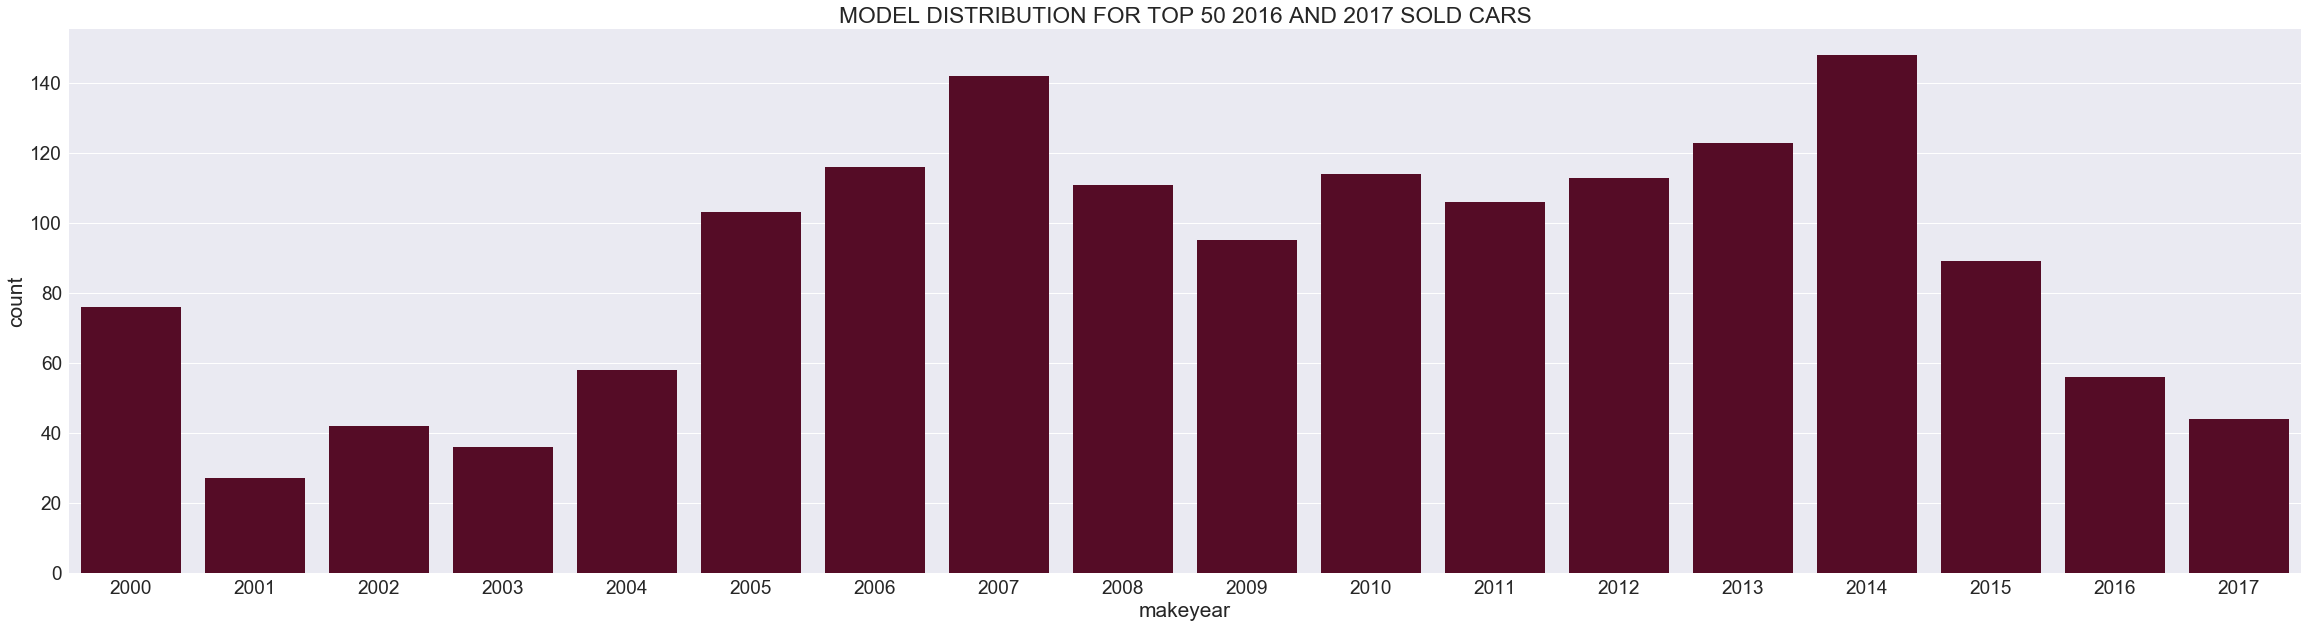

In [66]:
sns.set_context("notebook",font_scale=1.9)
plt.figure(figsize=(40,10))
plt.title('MODEL DISTRIBUTION FOR TOP 50 2016 AND 2017 SOLD CARS')
g = sns.countplot(octavia['makeyear'], color="#610023")
rotg = g.set_xticklabels(g.get_xticklabels())

In [67]:
error_meds = octavia.groupby(by='makeyear')['prabs'].median()
error_meds = error_meds.to_frame()
error_meds.reset_index(inplace=True)
error_meds

,makeyear,prabs
0,2000,14.55
1,2001,24.50
2,2002,19.50
3,2003,26.25
4,2004,36.25
5,2005,42.30
6,2006,42.40
7,2007,48.40
8,2008,51.00
9,2009,57.40


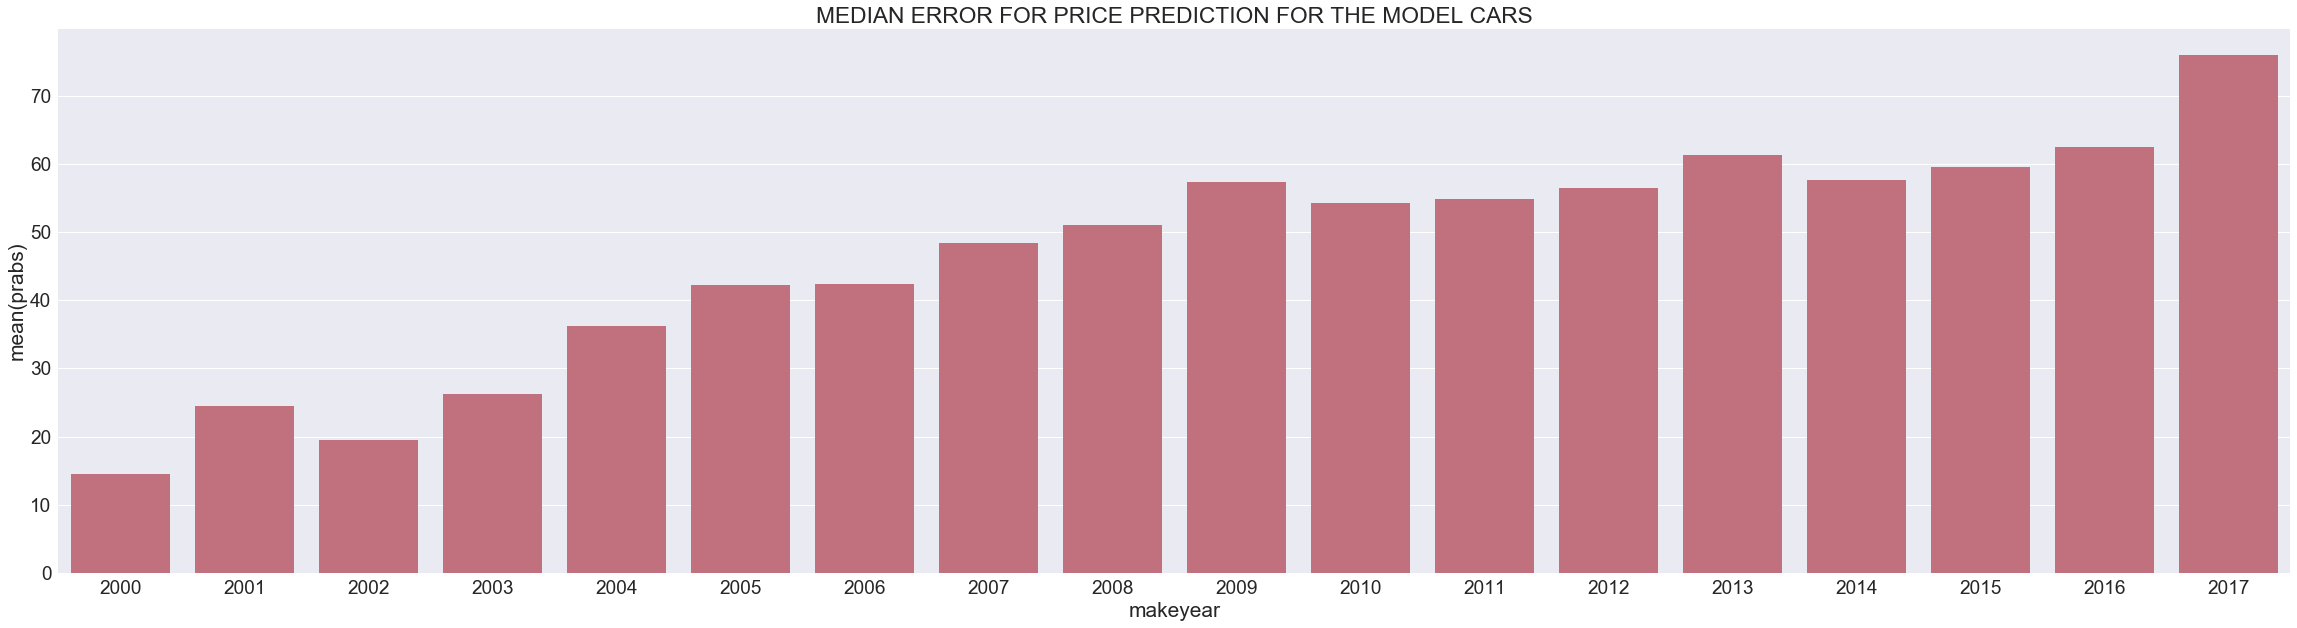

In [68]:
sns.set_context("notebook",font_scale=1.9)
plt.figure(figsize=(40,10))
plt.title('MEDIAN ERROR FOR PRICE PREDICTION FOR THE MODEL CARS')
g = sns.barplot("makeyear", "prabs", data=error_meds, color="#cf6275")
#rotg = g.set_xticklabels(makeyears)

In [69]:
error_meds = octavia.groupby(by='price')['prabs'].median()
error_meds = error_meds.to_frame()
error_meds.reset_index(inplace=True)

In [70]:
octavia.columns

Index(['id', 'make', 'model', 'make_model', 'makeyear', 'kilometer', 'age',
       'power', 'sizeccm', 'body', 'fueltype', 'automat', 'drive', 'mec_con',
       'ext_con', 'isfirstowner', 'isservicebook', 'isvat', 'autoaircondition',
       'airconditioned', 'isxenon', 'isled', 'isnavigation', 'iscruisecontrol',
       'isinleather', 'airbags', 'revage', 'revkm', 'make_cd', 'model_cd',
       'body_cd', 'fuel_cd', 'segment', 'anchor', 'price', 'tscode', 'counts',
       'adiff%', 'anabs', 'pred_price', 'diff%', 'prabs'],
      dtype='object')

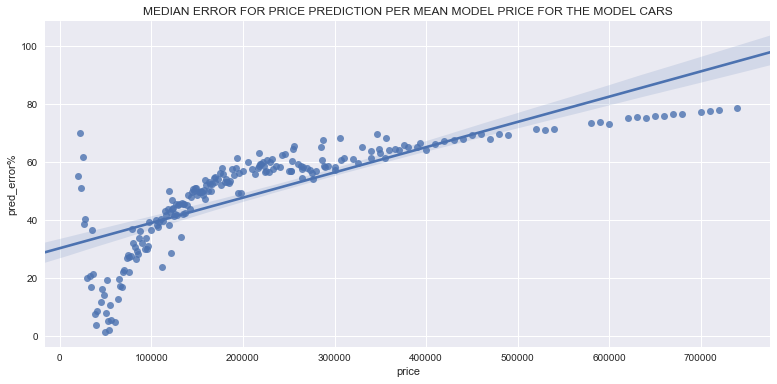

In [71]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,6))
sns.regplot(x = error_meds['price'], y =error_meds['prabs'])
plt.title('MEDIAN ERROR FOR PRICE PREDICTION PER MEAN MODEL PRICE FOR THE MODEL CARS')
plt.xlabel('price')
plt.ylabel('pred_error%')
sns.plt.show()

In [72]:
octavia_up = octavia[octavia.price>100000]
error_meds = octavia_up.groupby(by='price')['prabs'].median()
error_meds = error_meds.to_frame()
error_meds.reset_index(inplace=True)

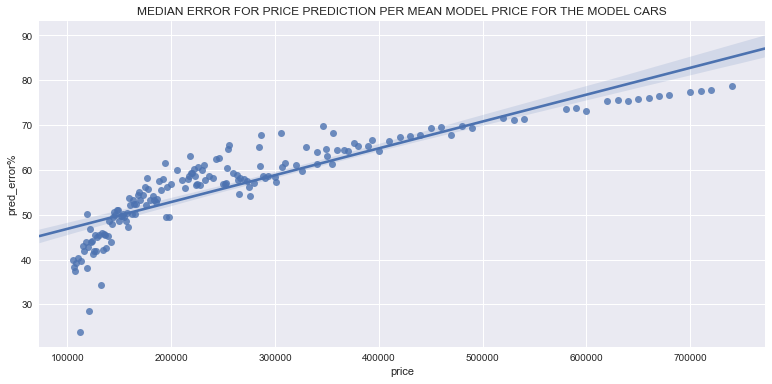

In [73]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,6))
sns.regplot(x = error_meds['price'], y =error_meds['prabs'])
plt.title('MEDIAN ERROR FOR PRICE PREDICTION PER MEAN MODEL PRICE FOR THE MODEL CARS')
plt.xlabel('price')
plt.ylabel('pred_error%')
sns.plt.show()

In [74]:
octavia0 = octavia[octavia.segment==0]

In [75]:
len(octavia0)

83

In [76]:
octavia0['prabs'].median()

19.9

In [77]:
octavia[octavia.prabs>20]

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,segment,anchor,price,tscode,counts,adiff%,anabs,pred_price,diff%,prabs
1187,900147079,skoda,octavia,skodaoctavia,2006,247.206,273,77,1896,hatchback,...,1060.0,120,66000,1,9136.0,81.8,81.8,49090,-25.6,25.6
1178,900151862,skoda,octavia,skodaoctavia,2006,286.548,287,77,1896,hatchback,...,1070.0,110,105000,1,9136.0,4.8,4.8,57030,-45.7,45.7
1185,900147428,skoda,octavia,skodaoctavia,2006,258.267,289,103,1968,combi,...,1072.0,115,85000,1,9136.0,35.3,35.3,60030,-29.4,29.4
1184,900150414,skoda,octavia,skodaoctavia,2006,259.206,291,103,1968,combi,...,1072.0,115,100000,1,9136.0,15.0,15.0,59969,-40.0,40.0
1183,900143466,skoda,octavia,skodaoctavia,2006,268.082,281,103,1968,combi,...,1072.0,115,90000,1,9136.0,27.8,27.8,59575,-33.8,33.8
1182,900149057,skoda,octavia,skodaoctavia,2006,299.455,271,103,1968,combi,...,1072.0,115,110000,1,9136.0,4.5,4.5,66424,-39.6,39.6
1181,900145511,skoda,octavia,skodaoctavia,2006,254.036,281,103,1968,hatchback,...,1072.0,115,100000,1,9136.0,15.0,15.0,63484,-36.5,36.5
1180,900151082,skoda,octavia,skodaoctavia,2006,263.306,283,77,1896,combi,...,1070.0,110,123000,1,9136.0,-10.6,10.6,64272,-47.7,47.7
1179,900152678,skoda,octavia,skodaoctavia,2006,276.503,285,77,1896,hatchback,...,1070.0,110,85000,1,9136.0,29.4,29.4,60848,-28.4,28.4
1186,900150868,skoda,octavia,skodaoctavia,2006,281.708,277,103,1968,combi,...,1072.0,115,110000,1,9136.0,4.5,4.5,65606,-40.4,40.4


In [78]:
octavia[octavia.id==900139124]

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,segment,anchor,price,tscode,counts,adiff%,anabs,pred_price,diff%,prabs
1221,900139124,skoda,octavia,skodaoctavia,2010,337.218,185,75,1595,hatchback,...,0.0,210,83000,1,9136.0,153.0,153.0,69060,-16.8,16.8


In [79]:
octavia[octavia.id==900139124][imp_cols]

,fueltype,automat,drive,mec_con,ext_con,isfirstowner,isservicebook,isvat,autoaircondition,airconditioned,isxenon,isled,isnavigation,iscruisecontrol,isinleather,airbags
1221,petrol,0,0,3,3,1,1,0,0,1,0,0,0,0,0,0


In [80]:
octavia.head(20)

,id,make,model,make_model,makeyear,kilometer,age,power,sizeccm,body,...,segment,anchor,price,tscode,counts,adiff%,anabs,pred_price,diff%,prabs
1187,900147079,skoda,octavia,skodaoctavia,2006,247.206,273,77,1896,hatchback,...,1060.0,120,66000,1,9136.0,81.8,81.8,49090,-25.6,25.6
1178,900151862,skoda,octavia,skodaoctavia,2006,286.548,287,77,1896,hatchback,...,1070.0,110,105000,1,9136.0,4.8,4.8,57030,-45.7,45.7
1185,900147428,skoda,octavia,skodaoctavia,2006,258.267,289,103,1968,combi,...,1072.0,115,85000,1,9136.0,35.3,35.3,60030,-29.4,29.4
1184,900150414,skoda,octavia,skodaoctavia,2006,259.206,291,103,1968,combi,...,1072.0,115,100000,1,9136.0,15.0,15.0,59969,-40.0,40.0
1183,900143466,skoda,octavia,skodaoctavia,2006,268.082,281,103,1968,combi,...,1072.0,115,90000,1,9136.0,27.8,27.8,59575,-33.8,33.8
1182,900149057,skoda,octavia,skodaoctavia,2006,299.455,271,103,1968,combi,...,1072.0,115,110000,1,9136.0,4.5,4.5,66424,-39.6,39.6
1181,900145511,skoda,octavia,skodaoctavia,2006,254.036,281,103,1968,hatchback,...,1072.0,115,100000,1,9136.0,15.0,15.0,63484,-36.5,36.5
1180,900151082,skoda,octavia,skodaoctavia,2006,263.306,283,77,1896,combi,...,1070.0,110,123000,1,9136.0,-10.6,10.6,64272,-47.7,47.7
1179,900152678,skoda,octavia,skodaoctavia,2006,276.503,285,77,1896,hatchback,...,1070.0,110,85000,1,9136.0,29.4,29.4,60848,-28.4,28.4
1186,900150868,skoda,octavia,skodaoctavia,2006,281.708,277,103,1968,combi,...,1072.0,115,110000,1,9136.0,4.5,4.5,65606,-40.4,40.4


In [81]:
def nice_mm(mo):
    return (mo+' ')

In [82]:
mycars1['make'] = mycars1['make'].apply(nice_mm) 

In [83]:
def unify_mm(mo):
    if (mo=='zafira tourer'):
        return 'zafira'
    if (mo=='megane scenic'):
        return 'scenic'
    return mo
mycars1['model'] = mycars1['make'] + mycars1['model']

In [84]:
mycars1['model'] = mycars1['model'].apply(unify_mm) 

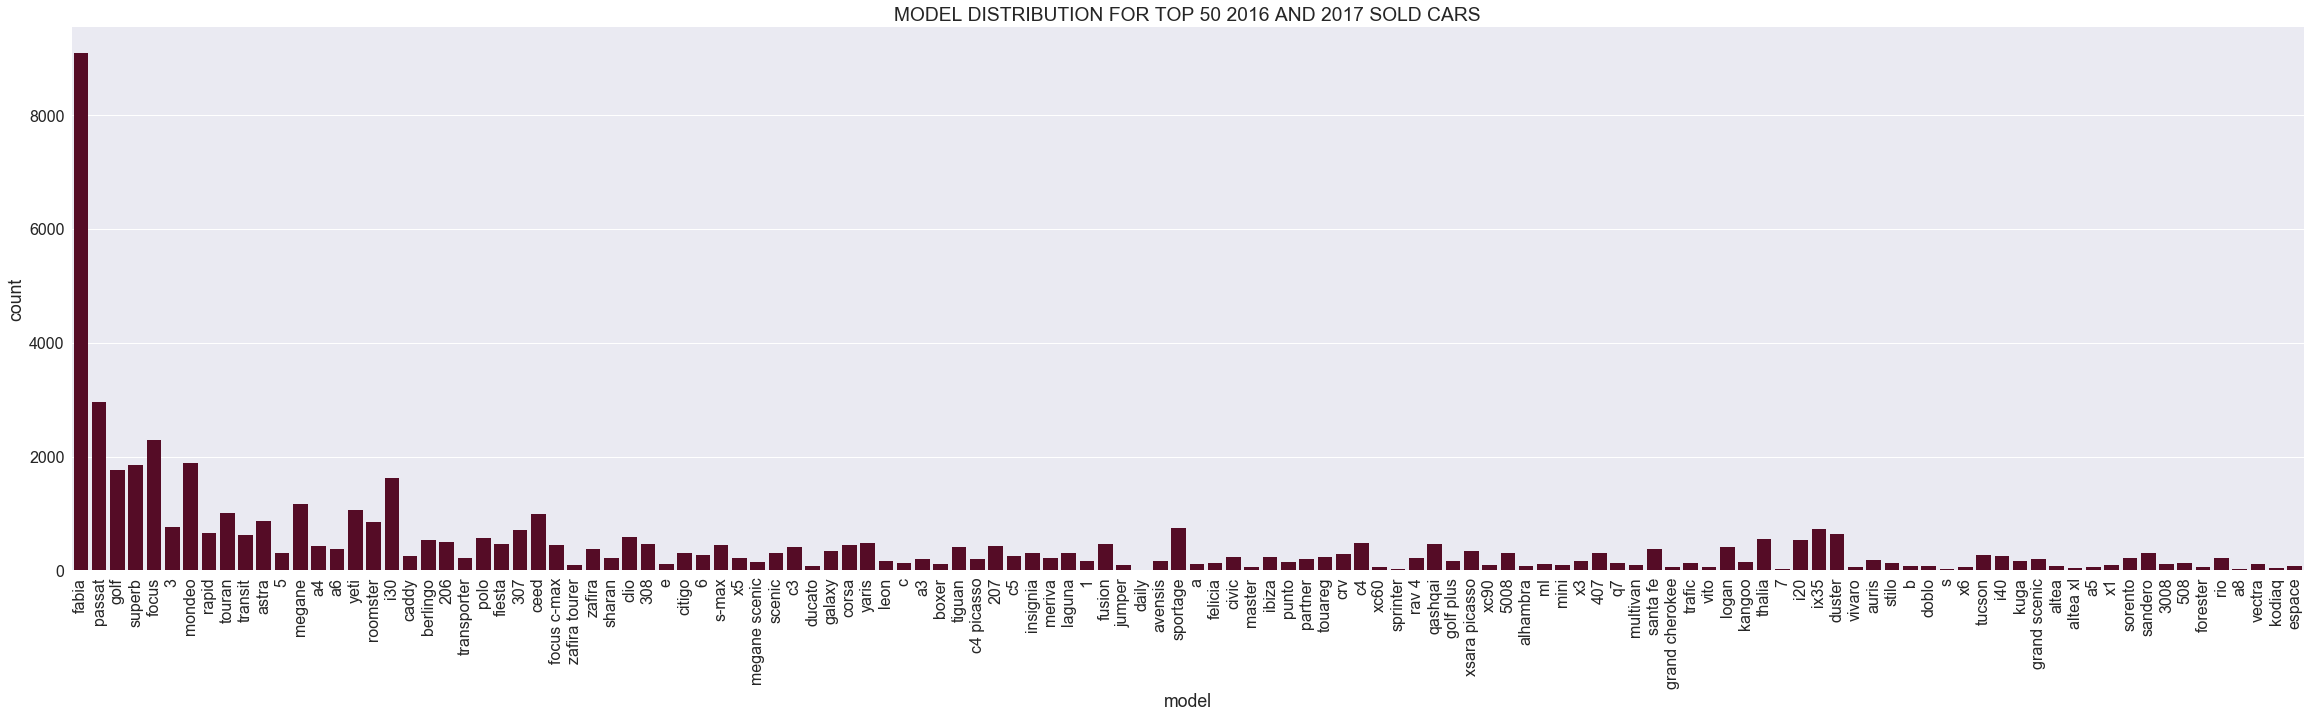

In [85]:
sns.set_context("notebook",font_scale=1.6)
plt.figure(figsize=(40,10))
plt.title('MODEL DISTRIBUTION FOR TOP 50 2016 AND 2017 SOLD CARS')
g = sns.countplot(carsTop['model'], color="#610023")
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=90)

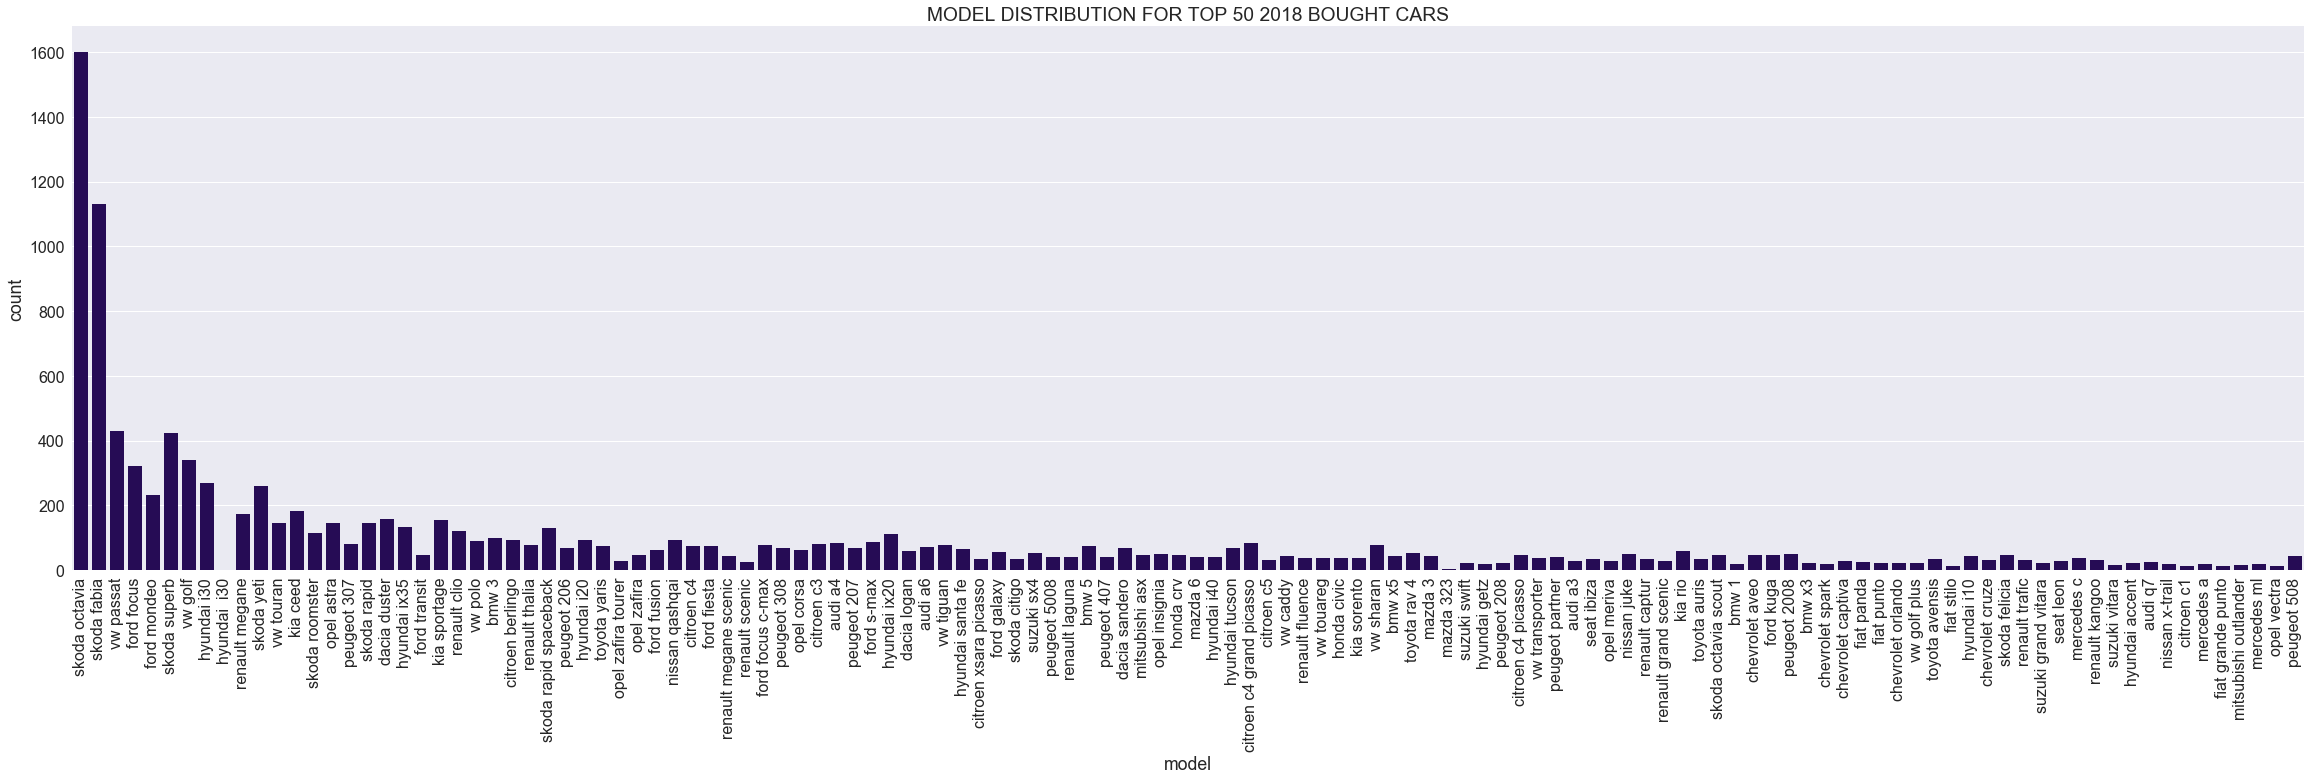

In [86]:
sns.set_context("notebook",font_scale=1.6)
plt.figure(figsize=(40,10))
plt.title('MODEL DISTRIBUTION FOR TOP 50 2018 BOUGHT CARS')
g = sns.countplot(mycars1['model'], color="#230061")
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=90)